# Задание 1.2 - Линейный классификатор (Linear classifier)

В этом задании мы реализуем другую модель машинного обучения - линейный классификатор. Линейный классификатор подбирает для каждого класса веса, на которые нужно умножить значение каждого признака и потом сложить вместе.
Тот класс, у которого эта сумма больше, и является предсказанием модели.

В этом задании вы:
- потренируетесь считать градиенты различных многомерных функций
- реализуете подсчет градиентов через линейную модель и функцию потерь softmax
- реализуете процесс тренировки линейного классификатора
- подберете параметры тренировки на практике

На всякий случай, еще раз ссылка на туториал по numpy:  
http://cs231n.github.io/python-numpy-tutorial/

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
path = '/content/drive/MyDrive/deep learning/Linear_sol'
import sys; sys.path.append(path)

In [3]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

%load_ext autoreload
%autoreload 2

In [6]:
from dataset        import load_svhn, random_split_train_val
from gradient_check import check_gradient
from metrics        import multiclass_accuracy 
import linear_classifer

# Как всегда, первым делом загружаем данные

Мы будем использовать все тот же SVHN.

In [7]:
def prepare_for_linear_classifier(train_X, test_X):
    train_flat = train_X.reshape(train_X.shape[0], -1).astype(np.float) / 255.0
    test_flat  = test_X .reshape(test_X.shape[0],  -1).astype(np.float) / 255.0
    
    # Subtract mean
    mean_image = np.mean(train_flat, axis = 0)
    train_flat -= mean_image
    test_flat  -= mean_image
    
    # Add another channel with ones as a bias term
    train_flat_with_ones = np.hstack([train_flat, np.ones((train_X.shape[0], 1))])
    test_flat_with_ones = np.hstack([test_flat, np.ones((test_X.shape[0], 1))])    
    return train_flat_with_ones, test_flat_with_ones
    
train_X, train_y, test_X, test_y = load_svhn(path+"/data", max_train=10000, max_test=1000)    
train_X, test_X = prepare_for_linear_classifier(train_X, test_X)
# Split train into train and val
train_X, train_y, val_X, val_y = random_split_train_val(train_X, train_y, num_val = 1000)

# Играемся с градиентами!

В этом курсе мы будем писать много функций, которые вычисляют градиенты аналитическим методом.

Необходимым инструментом во время реализации кода, вычисляющего градиенты, является функция его проверки. Эта функция вычисляет градиент численным методом и сверяет результат с градиентом, вычисленным аналитическим методом.

Мы начнем с того, чтобы реализовать вычисление численного градиента (numeric gradient) в этой функции.
Вычислите градиент с помощью численной производной для каждой координаты. Для вычисления производной используйте так называемую two-point formula (https://en.wikipedia.org/wiki/Numerical_differentiation):

![image](https://wikimedia.org/api/rest_v1/media/math/render/svg/22fc2c0a66c63560a349604f8b6b39221566236d)


In [8]:
# TODO: Implement gradient check function in gradient_check.py
def sqr(x):
    return x*x, 2*x

check_gradient(sqr, np.array([3.0]))

def array_sum(x):
    assert x.shape == (2,), x.shape
    return np.sum(x), np.ones_like(x)

check_gradient(array_sum, np.array([3.0, 2.0]))

def array_2d_sum(x):
    assert x.shape == (2,2)
    return np.sum(x), np.ones_like(x)

check_gradient(array_2d_sum, np.array([[3.0, 2.0], [1.0, 0.0]]))

Gradient check passed!
Gradient check passed!
Gradient check passed!


True

Теперь реализуем функцию softmax, которая получает на вход оценки для каждого класса и преобразует их в вероятности от 0 до 1:
![image](https://wikimedia.org/api/rest_v1/media/math/render/svg/e348290cf48ddbb6e9a6ef4e39363568b67c09d3)

**Важно:** Практический аспект вычисления этой функции заключается в том, что в ней учавствует вычисление экспоненты от потенциально очень больших чисел - это может привести к очень большим значениям в числителе и знаменателе за пределами диапазона float.

К счастью, у этой проблемы есть простое решение -- перед вычислением softmax вычесть из всех оценок максимальное значение среди всех оценок:
```
predictions -= np.max(predictions)
```
(подробнее здесь - http://cs231n.github.io/linear-classify/#softmax, секция `Practical issues: Numeric stability`)




$
\frac{e^{f_{y_i}}}{\sum_j e^{f_j}}
= \frac{Ce^{f_{y_i}}}{C\sum_j e^{f_j}}
= \frac{e^{f_{y_i} + log C}}{\sum_j e^{f_j + log C}}, \\
log C = -max (f_{y_i})
$




In [9]:
# TODO Implement softmax and cross-entropy for single sample
probs = linear_classifer.softmax(np.array([-10, 0, 10]))
print(probs)
print(probs.sum())

# Make sure it works for big numbers too!
probs = linear_classifer.softmax(np.array([1000, 0, 0]))
assert np.isclose(probs[0], 1.0)
print(probs)

[2.06106005e-09 4.53978686e-05 9.99954600e-01]
0.9999999999999999
[1. 0. 0.]


Кроме этого, мы реализуем cross-entropy loss, которую мы будем использовать как функцию ошибки (error function).
В общем виде cross-entropy определена следующим образом:
![image](https://wikimedia.org/api/rest_v1/media/math/render/svg/0cb6da032ab424eefdca0884cd4113fe578f4293)

где x - все классы, p(x) - истинная вероятность принадлежности сэмпла классу x, а q(x) - вероятность принадлежности классу x, предсказанная моделью.  
В нашем случае сэмпл принадлежит только одному классу, индекс которого передается функции. Для него p(x) равна 1, а для остальных классов - 0. 

Это позволяет реализовать функцию проще!

In [10]:
probs = linear_classifer.softmax(np.array([-5, 0, 5]))
linear_classifer.cross_entropy_loss(probs, 1)

5.006760443547122

После того как мы реализовали сами функции, мы можем реализовать градиент.

Оказывается, что вычисление градиента становится гораздо проще, если объединить эти функции в одну, которая сначала вычисляет вероятности через softmax, а потом использует их для вычисления функции ошибки через cross-entropy loss.

Эта функция `softmax_with_cross_entropy` будет возвращает и значение ошибки, и градиент по входным параметрам. Мы проверим корректность реализации с помощью `check_gradient`.

**P.S.** Зная производную функции *softmax*, мы можем правильно вычислить производную *cross-entropy loss*
![image](https://latex.codecogs.com/gif.latex?%5Cbegin%7Balign*%7D%20%5Cfrac%7B%5Cpartial%20smax%28x_i%29%7D%7B%5Cpartial%20x_i%7D%20%26%3D%5Cfrac%7Bf%27%28x%29g%28x%29-f%28x%29g%27%28x%29%7D%7Bg%28x%29%5E2%7D%20%5C%5C%5C%5C%20%26%3D%20%5Cfrac%7Be%5E%7Bx_i%7D%5Csum_%7Bj%3D1%7D%5E%7B%7CX%7C%7D%7Be%5E%7Bx_j%7D%7D%20-%20e%5E%7Bx_i%7D%5Cfrac%7B%5Cpartial%7D%7Bx_i%7D%7B%7D%5Csum_%7Bj%3D1%7D%5E%7B%7CX%7C%7D%7Be%5E%7Bx_j%7D%7D%20%7D%7B%28%5Csum_%7Bj%3D1%7D%5E%7B%7CX%7C%7D%7Be%5E%7Bx_j%7D%29%5E2%7D%7D%5C%5C%5C%5C%20%26%3D%20%5Cfrac%7Be%5E%7Bx_i%7D%5Csum_%7Bj%3D1%7D%5E%7B%7CX%7C%7D%7Be%5E%7Bx_j%7D%7D%20-%20%28e%5E%7Bx_i%7D%29%5E2%7D%7B%28%5Csum_%7Bj%3D1%7D%5E%7B%7CX%7C%7D%7Be%5E%7Bx_j%7D%29%5E2%7D%7D%5C%5C%5C%5C%20%26%3D%20%5Cleft%20%28%20%5Cfrac%7Be%5E%7Bx_i%7D%7D%7B%5Csum_%7Bj%3D1%7D%5E%7B%7CX%7C%7D%7Be%5E%7Bx_j%7D%7D%7D%5Cfrac%7B%5Csum_%7Bj%3D1%7D%5E%7B%7CX%7C%7D%7Be%5E%7Bx_j%7D%7D%7D%7B%5Csum_%7Bj%3D1%7D%5E%7B%7CX%7C%7D%7Be%5E%7Bx_j%7D%7D%7D%5Cright%20%29%20-%20%5Cleft%20%28%20%5Cfrac%7Be%5E%7Bx_i%7D%7D%7B%5Csum_%7Bj%3D1%7D%5E%7B%7CX%7C%7D%7Be%5E%7Bx_j%7D%7D%7D%5Cfrac%7Be%5E%7Bx_i%7D%7D%7B%5Csum_%7Bj%3D1%7D%5E%7B%7CX%7C%7D%7Be%5E%7Bx_j%7D%7D%7D%5Cright%20%29%5C%5C%5C%5C%20%26%3D%5Cfrac%7Be%5E%7Bx_i%7D%7D%7B%5Csum_%7Bj%3D1%7D%5E%7B%7CX%7C%7D%7Be%5E%7Bx_j%7D%7D%7D%5Cleft%20%281-%20%5Cfrac%7Be%5E%7Bx_i%7D%7D%7B%5Csum_%7Bj%3D1%7D%5E%7B%7CX%7C%7D%7Be%5E%7Bx_j%7D%7D%7D%5Cright%20%29%5C%5C%5C%5C%20%26%3D%20smax%28x_i%29%281-smax%28x_i%29%29%20%5Cend%7Balign*%7D)

In [11]:
# TODO Implement combined function or softmax and cross entropy and produces gradient
loss, grad = linear_classifer.softmax_with_cross_entropy(np.array([1, 0, 0]), 1)
check_gradient(lambda x: linear_classifer.softmax_with_cross_entropy(x, 1), np.array([1, 0, 0], np.float))

Gradient check passed!


True

В качестве метода тренировки мы будем использовать стохастический градиентный спуск (stochastic gradient descent или SGD), который работает с батчами сэмплов. 

Поэтому все наши фукнции будут получать не один пример, а батч, то есть входом будет не вектор из `num_classes` оценок, а матрица размерности `batch_size, num_classes`. Индекс примера в батче всегда будет первым измерением.

Следующий шаг - переписать наши функции так, чтобы они поддерживали батчи.

Финальное значение функции ошибки должно остаться числом, и оно равно среднему значению ошибки среди всех примеров в батче.

In [12]:
# TODO Extend combined function so it can receive a 2d array with batch of samples
np.random.seed(42)

num_classes = 4


batch_size  = 1
predictions  = np.random.randint(-1, 3, size=(batch_size, num_classes)).astype(np.float)
target_index = np.random.randint(0, num_classes, size=batch_size).astype(np.int)
check_gradient(lambda x: linear_classifer.softmax_with_cross_entropy(x, target_index), predictions)


batch_size = 3
predictions = np.random.randint(-1, 3, size=(batch_size, num_classes)).astype(np.float)
target_index = np.random.randint(0, num_classes, size=batch_size).astype(np.int)
check_gradient(lambda x: linear_classifer.softmax_with_cross_entropy(x, target_index), predictions)


Gradient check passed!
Gradient check passed!


True

### Наконец, реализуем сам линейный классификатор!

softmax и cross-entropy получают на вход оценки, которые выдает линейный классификатор.

Он делает это очень просто: для каждого класса есть набор весов, на которые надо умножить пиксели картинки и сложить. Получившееся число и является оценкой класса, идущей на вход softmax.

Таким образом, линейный классификатор можно представить как умножение вектора с пикселями на матрицу W размера `num_features, num_classes`. Такой подход легко расширяется на случай батча векторов с пикселями X размера `batch_size, num_features`:

`predictions = X * W`, где `*` - матричное умножение.

Реализуйте функцию подсчета линейного классификатора и градиентов по весам `linear_softmax` в файле `linear_classifer.py`

In [13]:
# TODO Implement linear_softmax function that uses softmax with cross-entropy for linear classifier
batch_size = 2
num_classes = 2
num_features = 3
np.random.seed(42)

W = np.random.randint(-1, 3, size=(num_features, num_classes)).astype(np.float)
X = np.random.randint(-1, 3, size=(batch_size,  num_features)).astype(np.float)
target_index = np.ones(batch_size, dtype=np.int)

loss, dW = linear_classifer.linear_softmax(X, W, target_index)
check_gradient(lambda w: linear_classifer.linear_softmax(X, w, target_index), W)

Gradient check passed!


True

### И теперь регуляризация

Мы будем использовать L2 regularization для весов как часть общей функции ошибки.

Напомним, L2 regularization определяется как

l2_reg_loss = regularization_strength * sum<sub>ij</sub> W[i, j]<sup>2</sup>

Реализуйте функцию для его вычисления и вычисления соотвествующих градиентов.

In [14]:
# TODO Implement l2_regularization function that implements loss for L2 regularization
linear_classifer.l2_regularization(W, 0.01)
check_gradient(lambda w: linear_classifer.l2_regularization(w, 0.01), W)

Gradient check passed!


True

# Тренировка!

Градиенты в порядке, реализуем процесс тренировки!

In [24]:
# TODO: Implement LinearSoftmaxClassifier.fit function
classifier = linear_classifer.LinearSoftmaxClassifier(learning_rate=1e-3, reg_rate=1e1)
loss_history = classifier.fit(train_X, train_y, epochs=2000, batch_size=500)

Epoch 0, loss: 2.607971
Epoch 10, loss: 2.505715
Epoch 20, loss: 2.437716
Epoch 30, loss: 2.393133
Epoch 40, loss: 2.362792
Epoch 50, loss: 2.341607
Epoch 60, loss: 2.329243
Epoch 70, loss: 2.319277
Epoch 80, loss: 2.313977
Epoch 90, loss: 2.310180
Epoch 100, loss: 2.307925
Epoch 110, loss: 2.306026
Epoch 120, loss: 2.304165
Epoch 130, loss: 2.304088
Epoch 140, loss: 2.302620
Epoch 150, loss: 2.302458
Epoch 160, loss: 2.301161
Epoch 170, loss: 2.302448
Epoch 180, loss: 2.301958
Epoch 190, loss: 2.302456
Epoch 200, loss: 2.301674
Epoch 210, loss: 2.301381
Epoch 220, loss: 2.301837
Epoch 230, loss: 2.302290
Epoch 240, loss: 2.301859
Epoch 250, loss: 2.301909
Epoch 260, loss: 2.302140
Epoch 270, loss: 2.301570
Epoch 280, loss: 2.301863
Epoch 290, loss: 2.301783
Epoch 300, loss: 2.301764
Epoch 310, loss: 2.301512
Epoch 320, loss: 2.302440
Epoch 330, loss: 2.302044
Epoch 340, loss: 2.301061
Epoch 350, loss: 2.302445
Epoch 360, loss: 2.301282
Epoch 370, loss: 2.301624
Epoch 380, loss: 2.3025

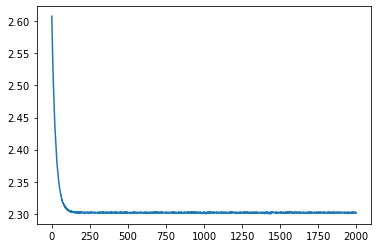

In [25]:
# let's look at the loss history!
plt.plot(loss_history);

In [26]:
# Let's check how it performs on validation set
pred = classifier.predict(val_X)
accuracy = multiclass_accuracy(pred, val_y)
print("Accuracy: ", accuracy)

# Now, let's train more and see if it performs better
classifier.fit(train_X, train_y, epochs=100, batch_size=300)
pred = classifier.predict(val_X)
accuracy = multiclass_accuracy(pred, val_y)
print("Accuracy after training for 100 epochs: ", accuracy)

Accuracy:  0.123
Epoch 0, loss: 2.607777
Epoch 10, loss: 2.506763
Epoch 20, loss: 2.438604
Epoch 30, loss: 2.392966
Epoch 40, loss: 2.362793
Epoch 50, loss: 2.342231
Epoch 60, loss: 2.330987
Epoch 70, loss: 2.320442
Epoch 80, loss: 2.313810
Epoch 90, loss: 2.310304
Accuracy after training for 100 epochs:  0.123


### Как и раньше, используем кросс-валидацию для подбора гиперпараметтов.

В этот раз, чтобы тренировка занимала разумное время, мы будем использовать только одно разделение на тренировочные (training) и проверочные (validation) данные.

Теперь нам нужно подобрать не один, а два гиперпараметра! Не ограничивайте себя изначальными значениями в коде.  
Добейтесь точности более чем **20%** на проверочных данных (validation data).

In [27]:
%%time
num_epochs = 200
batch_size = 300

learning_rates = [1e-2, 1e-3, 1e-4, 1e-5, 1e-6]
reg_strengths = [1e-3, 1e-4, 1e-5, 1e-6, 1e-7]

best_val_accuracy = 0
best_loss_history = None
best_classifier = None
best_params = {'learning_rate': None,
               'reg_strength': None}

# TODO use validation set to find the best hyperparameters
# hint: for best results, you might need to try more values for learning rate and regularization strength 
# than provided initially
for lr in learning_rates:
    for reg in reg_strengths:
        classifier = linear_classifer.LinearSoftmaxClassifier()
        loss_history = classifier.fit(train_X, train_y, verbose=False,
                                      epochs=num_epochs, batch_size=batch_size,
                                      learning_rate=lr, reg_rate=reg)
        
        pred = classifier.predict(val_X)
        accuracy = multiclass_accuracy(pred, val_y)
        print("Accuracy with lr={0}, reg={1}: {2}".format(lr, reg, accuracy))
        
        if accuracy > best_val_accuracy:
            best_val_accuracy = accuracy
            best_loss_history = loss_history
            best_classifier = classifier
            best_params['learning_rate'] = lr
            best_params['reg_strength'] = reg
        
print()
print('best validation accuracy achieved: %f' % best_val_accuracy)

Accuracy with lr=0.01, reg=0.001: 0.091
Accuracy with lr=0.01, reg=0.0001: 0.107
Accuracy with lr=0.01, reg=1e-05: 0.117
Accuracy with lr=0.01, reg=1e-06: 0.113
Accuracy with lr=0.01, reg=1e-07: 0.096
Accuracy with lr=0.001, reg=0.001: 0.108
Accuracy with lr=0.001, reg=0.0001: 0.089
Accuracy with lr=0.001, reg=1e-05: 0.099
Accuracy with lr=0.001, reg=1e-06: 0.094
Accuracy with lr=0.001, reg=1e-07: 0.093
Accuracy with lr=0.0001, reg=0.001: 0.132
Accuracy with lr=0.0001, reg=0.0001: 0.088
Accuracy with lr=0.0001, reg=1e-05: 0.101
Accuracy with lr=0.0001, reg=1e-06: 0.107
Accuracy with lr=0.0001, reg=1e-07: 0.111
Accuracy with lr=1e-05, reg=0.001: 0.107
Accuracy with lr=1e-05, reg=0.0001: 0.101
Accuracy with lr=1e-05, reg=1e-05: 0.087
Accuracy with lr=1e-05, reg=1e-06: 0.09
Accuracy with lr=1e-05, reg=1e-07: 0.148
Accuracy with lr=1e-06, reg=0.001: 0.091
Accuracy with lr=1e-06, reg=0.0001: 0.103
Accuracy with lr=1e-06, reg=1e-05: 0.132
Accuracy with lr=1e-06, reg=1e-06: 0.101
Accuracy wit

# Какой же точности мы добились на тестовых данных?

In [28]:
test_pred = best_classifier.predict(test_X)
test_accuracy = multiclass_accuracy(test_pred, test_y)
print('Linear softmax classifier test set accuracy: %f' % (test_accuracy, ))

Linear softmax classifier test set accuracy: 0.116000
